In [5]:

import os
os.environ['KERAS_BACKEND'] = 'torch'

import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import keras
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import ShuffleSplit
from keras import regularizers, layers

In [6]:
# PARAMS

FEATURES_FILE_PATH = "data/LEMON_DATA/CBraMod_features_gender.pt"
CLS_CHECKPOINT_PATH = 'logs/20250412_classifier_v3'
DEVICE = 'cpu'
DO_GROUPED_SHUFFLE = True

In [ ]:
# LOAD DATA (features and labels)

ds = torch.load(FEATURES_FILE_PATH, map_location=DEVICE, weights_only=False)

X_e = torch.from_numpy(ds['features']).to(device=DEVICE)
y = torch.from_numpy(ds['gender']).to(device=DEVICE).float()
X_e.shape, y.shape

(torch.Size([13832, 3200]), torch.Size([13832]), torch.Size([13832]))

In [ ]:
# SPLIT

if DO_GROUPED_SHUFFLE:
    groups = ds['subject_ids'].to(device=DEVICE)
    group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
    train_idx, val_idx = next(group_shuffle.split(X_e, y, groups=groups))
else:
    random_shuffle = ShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
    train_idx, val_idx = next(random_shuffle.split(X_e, y))

# random_shuffle = ShuffleSplit(n_splits=1, test_size=0.3, random_state=1)
# train_idx, val_idx = next(random_shuffle.split(X_e, y))


y.mean(), y[train_idx].mean(), y[val_idx].mean()

(tensor(0.5000), tensor(0.4999), tensor(0.5002))

In [9]:
callbacks = [
    keras.callbacks.ModelCheckpoint(f'{CLS_CHECKPOINT_PATH}.model.keras', monitor='val_accuracy', save_best_only=True),
    keras.callbacks.CSVLogger(f'{CLS_CHECKPOINT_PATH}.csv'),
    keras.callbacks.TerminateOnNaN()
]

cls_model = keras.models.Sequential([   
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

cls_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    # loss=keras.losses.Hinge(),
    # loss='mse',
    # loss=keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy'])

history = cls_model.fit(
    X_e[train_idx], y[train_idx],
    epochs=1000,
    batch_size=1024,
    validation_data=(X_e[val_idx], y[val_idx]),
    callbacks=callbacks,
    # class_weight=class_weights,
    shuffle=True)

history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{CLS_CHECKPOINT_PATH}_final.csv')
cls_model.save(f'{CLS_CHECKPOINT_PATH}_final.model.keras')

clear_output(wait=True)
print('Training finished!')

Training finished!


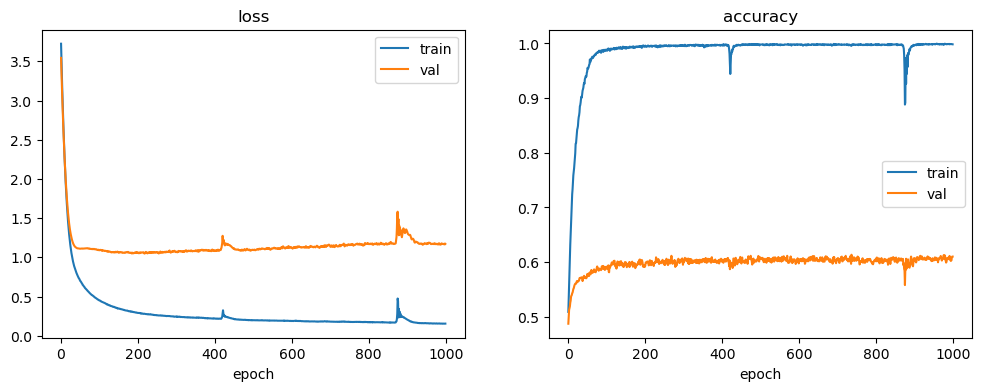

In [ ]:
# PLOTTING LOSS AND ACCURACY

def plot_history(history_df):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['loss'], label='train')
    plt.plot(history_df['val_loss'], label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('loss')

    plt.subplot(1, 2, 2)
    plt.plot(history_df['accuracy'], label='train')
    plt.plot(history_df['val_accuracy'], label='val')
    plt.legend()
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.show()

plot_history(history_df)

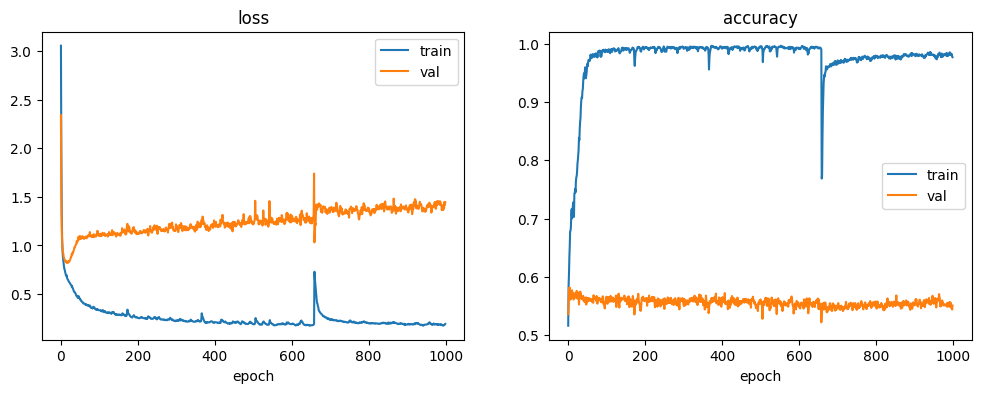

In [10]:
# PLOTTING LOSS AND ACCURACY

def plot_history(history_df):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['loss'], label='train')
    plt.plot(history_df['val_loss'], label='val')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('loss')

    plt.subplot(1, 2, 2)
    plt.plot(history_df['accuracy'], label='train')
    plt.plot(history_df['val_accuracy'], label='val')
    plt.legend()
    plt.title('accuracy')
    plt.xlabel('epoch')
    plt.show()

plot_history(history_df)